#### Requirements
please share the following documents:

1. The code used to generate your model results (i.e. attach your ".py" files or equivalents)

2. A README text file containing the following information:
    <ol>
- Your final model equation (if applicable)
- Your predicted number of orders given the following information:
    date = 2021-01-15
    region_id = 7
    email_opens = 10449
    avg_order_value = 48.02
    social_likes = 447
    total_site_visits = 282887

- A high-level, step-by-step explanation of how you developed your model and why you took that step
- An explanation for why you chose this model
    </ol>
3. Optionally, any other information or visuals that you think help explain the model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

### Exploratory Data Analysis 


In [2]:
df = pd.read_csv('Take_Home_Assignment_Data.tsv', sep='\t')
df['date'] = pd.to_datetime(df['date'])
print('df.shape: ', df.shape)
df.head()


df.shape:  (7320, 7)


,date,region_id,email_opens,avg_order_value,social_likes,total_site_visits,total_orders
0,2020-01-01,1,3229,33.15,256,56075,464
1,2020-01-01,2,8421,51.89,998,159320,739
2,2020-01-01,3,8859,45.41,1049,154371,737
3,2020-01-01,4,5740,43.50,683,111904,786
4,2020-01-01,5,5420,46.56,460,157213,712


In [3]:
print("EDA: df datatypes:")
print(df.dtypes)
print("\n\n EDA: df stats: ")
print(df.describe())
print("\n\n EDA: df nans")
print(df.isna().sum())

EDA: df datatypes:
date                 datetime64[ns]
region_id                     int64
email_opens                   int64
avg_order_value             float64
social_likes                  int64
total_site_visits             int64
total_orders                  int64
dtype: object


 EDA: df stats: 
         region_id   email_opens  avg_order_value  social_likes  \
count  7320.000000   7320.000000      7320.000000   7320.000000   
mean     10.500000   8381.830328        29.277234    591.775956   
std       5.766675   3841.843843        14.002776    305.971973   
min       1.000000    917.000000         4.870000     63.000000   
25%       5.750000   5623.000000        17.177500    322.000000   
50%      10.500000   7864.500000        29.260000    592.500000   
75%      15.250000  10635.250000        41.502500    856.000000   
max      20.000000  28229.000000        53.240000   1121.000000   

       total_site_visits  total_orders  
count        7320.000000   7320.000000  
mean      

### Visualize the distributions for numerical features

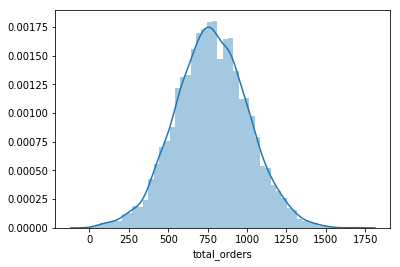

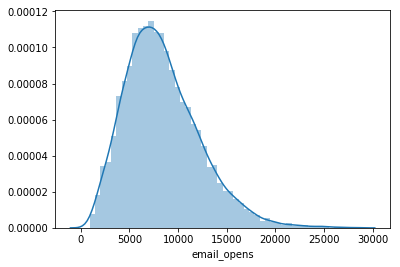

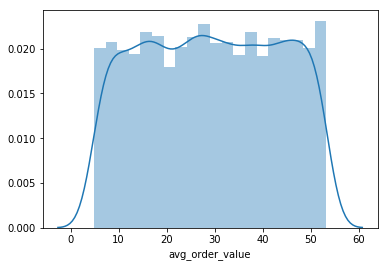

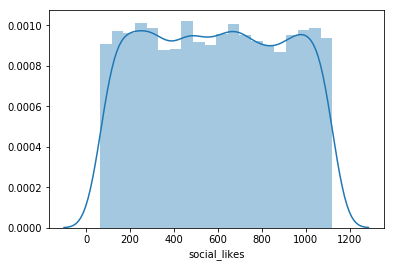

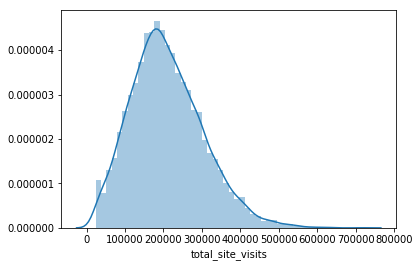

In [4]:
sns.distplot(df.total_orders) # normal distributed, this is the target
plt.show()
sns.distplot(df.email_opens) # right skewed normal distributed
plt.show()
sns.distplot(df.avg_order_value) # uniform distributed
plt.show()
sns.distplot(df.social_likes) # uniform distributed
plt.show()
sns.distplot(df.total_site_visits) # right skewed normal distributed
plt.show()


### Check the correlations

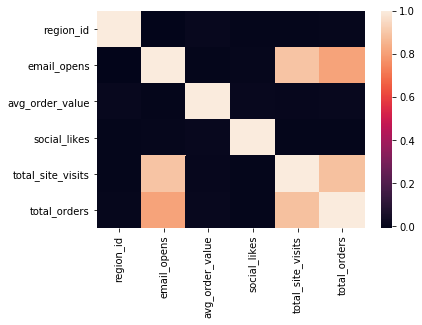

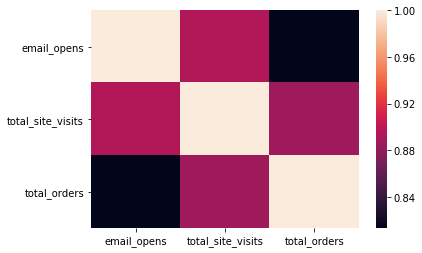

In [5]:
sns.heatmap(df.corr())
plt.show()

# now the total_order seems highly related to: total_site_visits and email_opens
sns.heatmap(df[['email_opens', 'total_site_visits', 'total_orders']].corr())
plt.show()

# however, total_site_visits and email_opens has high collinearity

## Explore the timestamps
### Questions: 
1. checkout the unique days in the dataset
2. is holidays or not making a difference to the total sale?
3. is weekday making a difference to the total sale?
4. is there autocorrelation in the data?


check: holidays are ['2020-01-01T00:00:00.000000000' '2020-01-20T00:00:00.000000000'
 '2020-02-17T00:00:00.000000000' '2020-05-25T00:00:00.000000000'
 '2020-07-03T00:00:00.000000000' '2020-09-07T00:00:00.000000000'
 '2020-10-12T00:00:00.000000000' '2020-11-11T00:00:00.000000000'
 '2020-11-26T00:00:00.000000000' '2020-12-25T00:00:00.000000000']
[20]


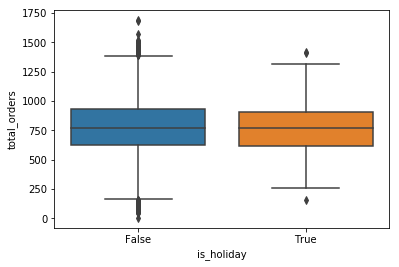

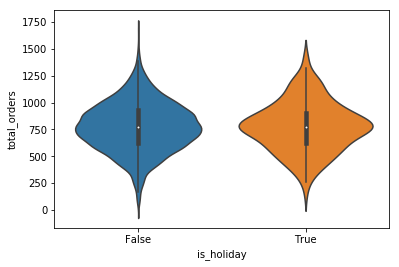

check weekday: [2 3 4 5 6 0 1]


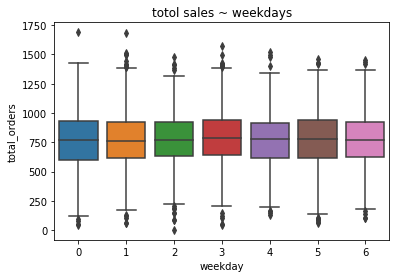

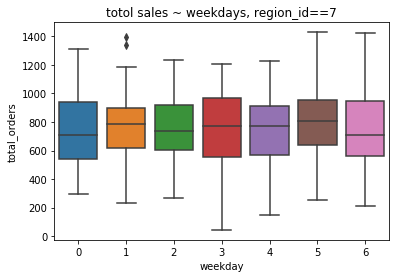

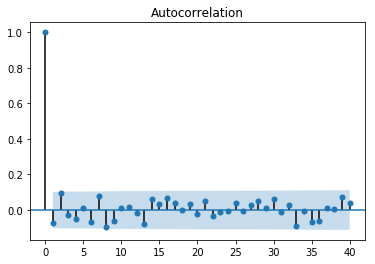

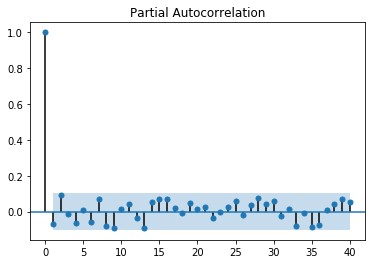

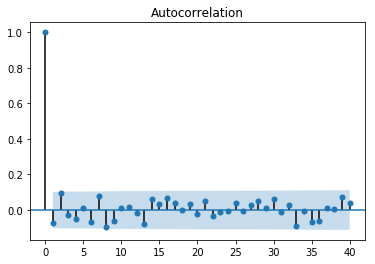

In [6]:
# explore the date
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
df.date.min()
df.date.max()
df.date.nunique()
cal = calendar()
holidays = cal.holidays(start=df.date.min(), end=df.date.max())

df['is_holiday'] = df['date'].isin(holidays) # add a flag, mark the date is holiday or not
df['date_cnt'] = df.groupby(['date'])['date'].transform('count')
print("check: holidays are {}".format(df.loc[df.is_holiday==True].date.unique()))
print(df.date_cnt.unique()) # [20], each date has 20 observations
assert df.shape[0] == df.drop_duplicates().shape[0] # there is no duplicates data entries
assert df.shape[0] == 20*df.date.nunique() # df is composed of a year's unique dates, each date has 20 observations

# check the plots with two categories
sns.boxplot(x="is_holiday", y="total_orders", data=df)
plt.show()
sns.violinplot(x="is_holiday", y="total_orders", kind="box", data=df)
plt.show()
df.groupby('is_holiday').describe()

# T-test, is holiday making a differce?
stats.ttest_ind(df.loc[df.is_holiday==True]['total_orders'], df.loc[df.is_holiday==False]['total_orders'])
# Ttest_indResult(statistic=0.17407107711715575, pvalue=0.8618144182137639)
# there is no significant difference btw holiday'sale and none-holiday's sale

df['weekday'] = df['date'].dt.dayofweek
print("check weekday: {}".format(df.weekday.unique()))
sns.boxplot(x="weekday", y="total_orders", data=df).set_title('totol sales ~ weekdays')
plt.show()
# From the plot, no significant differences

sns.boxplot(x="weekday", y="total_orders", data=df.loc[df.region_id==7]).set_title('totol sales ~ weekdays, region_id==7')
plt.show()

# check the auto-correlations
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df.loc[df.region_id==7].sort_values(['date'])['total_orders'], lags=40)
sm.graphics.tsa.plot_acf(df.loc[df.region_id==7].sort_values(['date'])['total_orders'], lags=40)
# No autocorrelation found in the dataset(by regions)


### Explore the regions
Questions: is region making a difference to the total sale?

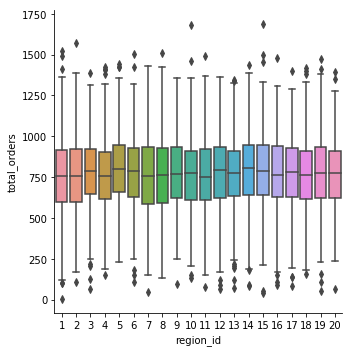

In [7]:
# explore regions
df.region_id.unique()
sns.catplot(x="region_id", y="total_orders", kind="box", data=df)
# no significant difference observed, we can do a ANOVA test to confirm this

### I doubt the region_id, date, avg_order_value, social_likes are not helpful preditors
### let's confirm this by a feature importance analysis

C:\Users\Wei\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Feature importance:
{'region_id': 0.021848485855226172, 'email_opens': 0.06265373274568273, 'avg_order_value': 0.03374129956637502, 'social_likes': 0.03369151390511307, 'total_site_visits': 0.8120547109934484, 'date_code': 0.03601025693415448}


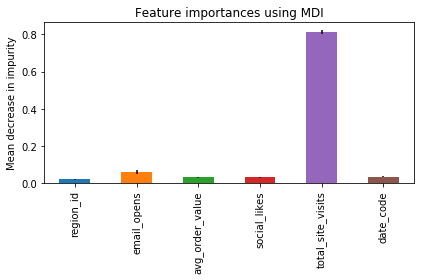

In [8]:
from sklearn.ensemble import RandomForestRegressor
features = ['date', 'region_id', 'email_opens', 'avg_order_value', 'social_likes', 'total_site_visits']
X = df[features]
y = df['total_orders']
X['date_code'] = (X.date - X.date.min()).dt.days
X = X.drop('date', axis=1)
X.head()

rf = RandomForestRegressor(n_estimators=300)
rf.fit(X, y)

print('Feature importance:')
print(dict(zip(X.columns, rf.feature_importances_)))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [9]:
# the feature importance gives us more insights.
# now, let's try to fix the skewed data columns, and try it again
import math
df['log_total_site_visits'] = df.total_site_visits.apply(math.log)
df['log_email_opens'] = df.email_opens.apply(math.log)

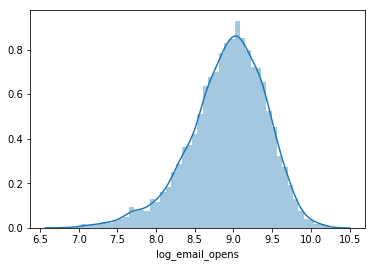

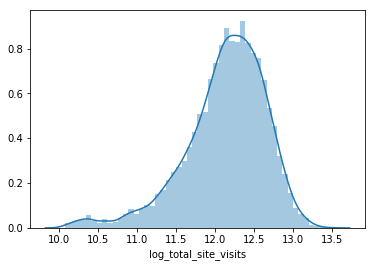

In [10]:
df[['email_opens', 'total_site_visits', 'log_email_opens','log_total_site_visits','total_orders']].head()
sns.distplot(df.log_email_opens) 
plt.show()

sns.distplot(df.log_total_site_visits) 
plt.show()

# it looks slightly better, but does this conversion helpful? we donot know yet.

In [11]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
features = ['log_email_opens','log_total_site_visits']
target = ['total_orders']
clf.fit(df[features], df[target])
#Lasso(alpha=0.1)
print(clf.coef_)
print(clf.intercept_)

#[231.53470394 657.13509285]
#[-3584.37767968]

[101.00964208 285.4631117 ]
[-3589.32585429]


### Experiments with different assumptions

#### question: what the formula should looks like

In [12]:
# use this dictionary to record the experiments
rmse_dic = {}

#### assumption 1:  c1 * log_email_opens + c2 * log_total_site_visits + b = toal_order

In [13]:
# Now let's assume the relationship is c1*log_email_opens + c2*log_total_site_visits + b = toal_order
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

df = df.reset_index(drop=True)
kf = KFold(n_splits=10, shuffle=True)

features = ['log_email_opens','log_total_site_visits']
target = ['total_orders']
X = df[features]
y = df[target]
lasso = linear_model.Lasso(alpha=0.1)
kf.get_n_splits(X)
rmses_test = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lasso.fit(X_train, y_train)
    #print(lasso.coef_)
    #print(lasso.intercept_)
    pred = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    rmses_test.append(rmse)

print(rmses_test)
rmse_dic['exp1'] = rmses_test


[121.83726274578352, 122.23338230444678, 120.13943445545335, 117.02240527395287, 120.64864717650912, 121.83517215873204, 110.29931413341947, 116.6195627488767, 115.0711126016992, 116.41476042142297]


#### assumption 2: c1 * email_opens + c2 * total_site_visits + b = toal_order

In [14]:
features = ['email_opens','total_site_visits']
target = ['total_orders']

X = df[features]
y = df[target]
rmses = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lasso.fit(X_train, y_train)
    #print(lasso.coef_)
    #print(lasso.intercept_)
    pred = lasso.predict(X_test)
    mean = mean_squared_error(y_test, pred) 
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    rmses.append(rmse)
print(rmses)
rmse_dic['exp2'] = rmses

#### The log transformation seems not very helpul

[104.60678938921222, 97.0090344013777, 114.32883272335414, 108.00859425243299, 106.36075159115816, 106.84710289396811, 108.46664274686164, 108.92290912291745, 99.87394246847302, 100.67949705465448]


#### assumption 3: c * total_site_visits + b = toal_order

In [15]:
features = ['total_site_visits']
target = ['total_orders']

X = df[features]
y = df[target]
rmses = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lasso.fit(X_train, y_train)
    #print(lasso.coef_)
    #print(lasso.intercept_)
    pred = lasso.predict(X_test)
    mean = mean_squared_error(y_test, pred) 
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    rmses.append(rmse)
print(rmses)

rmse_dic['exp3'] = rmses

[104.63369504122495, 106.6253177307359, 104.93732607757543, 108.87394816821356, 107.49602463507422, 108.57607479486191, 106.08878900121572, 103.69905698336254, 98.1624610254514, 110.81436472115803]


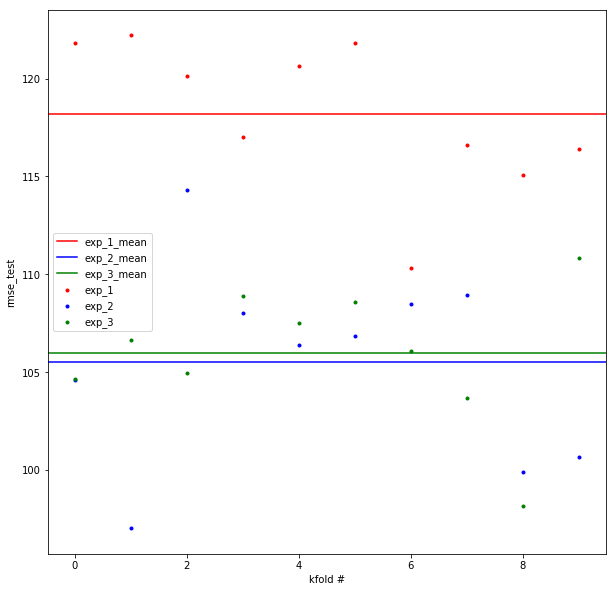

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(range(10), rmse_dic['exp1'], marker='.', label='exp_1', color='r')
ax.scatter(range(10), rmse_dic['exp2'], marker='.', label='exp_2', color='b')
ax.scatter(range(10), rmse_dic['exp3'], marker='.', label='exp_3', color='g')
ax.axhline(np.mean(rmse_dic['exp1']), label='exp_1_mean', color='r')
ax.axhline(np.mean(rmse_dic['exp2']), label='exp_2_mean', color='b')
ax.axhline(np.mean(rmse_dic['exp3']), label='exp_3_mean', color='g')
ax.legend()
ax.set_xlabel('kfold #')
ax.set_ylabel('rmse_test')
plt.show()


In [17]:
stats.ttest_ind(np.asarray(rmse_dic['exp2']), np.asarray(rmse_dic['exp3']))

# Ttest_indResult(statistic=-0.17594005627822645, pvalue=0.8623052753609227)
# there is no significant difference btw the mean of rmse-exp2 and rmse-exp3
# but the formula would be more concise using exp3

Ttest_indResult(statistic=-0.24512684640562088, pvalue=0.8091310909757535)

In [26]:
features = ['total_site_visits']
target = ['total_orders']

X = df[features]
y = df[target]
lasso.fit(X_train, y_train)
c = lasso.coef_[0]
b = lasso.intercept_[0]

print("The formula: {} * total_site_visits + {} = total_order".format(c, b))

# the formula is : 0.00216247 * total_site_visits + 321.98031572 = total_order
# now given the features like this:
condi = dict(date = '2021-01-15',
         region_id = 7,
         email_opens = 10449, 
         avg_order_value = 48.02,
         social_likes = 447, 
         total_site_visits = 282887
)
# we can put the numbers into the formula like: 282887 *  0.00216247 + 321.98031572

res = 282887 *  0.00216247 + 321.98031572 # 933.71496661
print("under this conditions of {}, we predict the total sale would be {}".format(str(condi), res))


The formula: 0.0021701595077865394 * total_site_visits + 320.9202356630472 = total_order
under this conditions of {'date': '2021-01-15', 'region_id': 7, 'email_opens': 10449, 'avg_order_value': 48.02, 'social_likes': 447, 'total_site_visits': 282887}, we predict the total sale would be 933.71496661
